### Adicionar infos do trabalho

### import libraries

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"On device: {device}")

On device: cuda


### Load data file

In [2]:
df = pd.read_csv("../data/diabetes_012_health_indicators_BRFSS2015.csv")
df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [3]:
df["Diabetes_012"].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

#### Transforme dataset to binary classification problem

In [4]:
df = df[df["Diabetes_012"] != 1.0]

In [5]:
df["Diabetes_012"].value_counts()

Diabetes_012
0.0    213703
2.0     35346
Name: count, dtype: int64

In [6]:
df["Diabetes_012"] = df["Diabetes_012"].replace({2.0: 1.0})

/tmp/ipykernel_16777/1443849391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Diabetes_012"] = df["Diabetes_012"].replace({2.0: 1.0})


#### Normalize numerical columns

In [7]:
Y = df["Diabetes_012"]
X = df.drop(columns={"Diabetes_012"})

In [8]:
scaler = MinMaxScaler()

for col in X.columns:

    if X[col].nunique() > 2:

        X[col] = scaler.fit_transform(X[[col]]).flatten()

In [9]:
X, Y = shuffle(X, Y, random_state=0)

In [10]:
class Data(Dataset):
    
    def __init__(self, data, targets):
        self.data = data.to_numpy()
        self.targets = targets.to_numpy()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.data[idx])).float(), torch.from_numpy(np.array(self.targets[idx])).float()

dataset = Data(X,Y)

In [11]:

batch_size = 256

train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Create model

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, layers, lr=0.001):
        super(MLP, self).__init__()
        all_layers = []
        prev_dim = input_dim

        # Camadas ocultas
        for layer_dim in layers:
            all_layers.append(nn.Linear(prev_dim, layer_dim))
            all_layers.append(nn.ReLU())
            prev_dim = layer_dim

        # Camada de saída (ativação linear - regressão)
        all_layers.append(nn.Linear(prev_dim, output_dim))
        all_layers.append(nn.Sigmoid())

        # Combinando as camadas
        self.layers = nn.Sequential(*all_layers)

        self.criterion = nn.L1Loss() #nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr=lr)

    def forward(self, x):
        return self.layers(x)
    
    def train_model(self, dataloader):
        self.train()
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.forward(batch_x)
            # print(f"Output: {len(outputs)}, batch_y: {len(batch_y)}")
            loss = self.criterion(outputs.view(outputs.shape[0]), batch_y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def validate_model(self, dataloader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self(batch_x)
                loss = self.criterion(outputs.view(outputs.shape[0]), batch_y)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def test_model(self, dataloader):
        self.eval()
        predictions = []
        targets = []
        total_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self.forward(batch_x)
                print(outputs)
                loss = self.criterion(outputs.flatten(), batch_y)
                total_loss += loss.item()
                predictions.extend(outputs.cpu().tolist())
                targets.append(batch_y.cpu().tolist())
        return predictions, targets, total_loss / len(dataloader)

    def predict(self, dataloader):
        self.eval()
        predictions = []
        with torch.no_grad():
            for batch_x, _ in dataloader:
                batch_x = batch_x.to(device)
                outputs = self(batch_x)
                predictions.extend(outputs.cpu().tolist())
        return predictions

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [14]:
num_epochs = 10
learning_rate = 0.001
# Definição do Modelo
model = MLP(input_dim=X.shape[1], output_dim=1, layers=[21], lr=learning_rate).to(device)

Época 10/10, Train Loss: 0.1652, Validation Loss: 0.1639


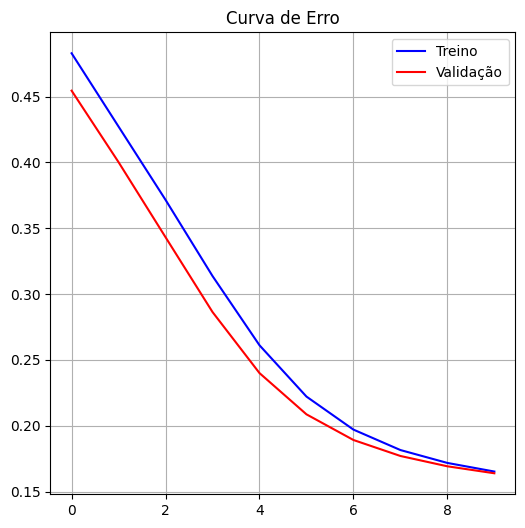

In [15]:
# Early Stop
early_stopping = EarlyStopping(patience=20, verbose=False)

tloss = []
vloss = []
for epoch in range(num_epochs):
    train_loss = model.train_model(train_loader)
    val_loss = model.validate_model(val_loader)
    tloss.append(train_loss)
    vloss.append(val_loss)
    if (epoch+1) % 10 == 0:
        print(f"Época {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Curva de Erro")
ax.plot(tloss,'blue', label='Treino')
ax.plot(vloss,'red', label='Validação')
ax.legend()
ax.grid(True)
plt.show()

In [16]:
Yp, Yt, total_loss = model.test_model(test_dataset)

tensor([0.0196], device='cuda:0')
tensor([0.0179], device='cuda:0')
tensor([0.0263], device='cuda:0')
tensor([0.0131], device='cuda:0')
tensor([0.0397], device='cuda:0')
tensor([0.0173], device='cuda:0')
tensor([0.0181], device='cuda:0')
tensor([0.0277], device='cuda:0')
tensor([0.0192], device='cuda:0')
tensor([0.0259], device='cuda:0')
tensor([0.0338], device='cuda:0')
tensor([0.0758], device='cuda:0')
tensor([0.0201], device='cuda:0')
tensor([0.0303], device='cuda:0')
tensor([0.0348], device='cuda:0')
tensor([0.0234], device='cuda:0')
tensor([0.0129], device='cuda:0')
tensor([0.0238], device='cuda:0')
tensor([0.0544], device='cuda:0')
tensor([0.0237], device='cuda:0')
tensor([0.0647], device='cuda:0')
tensor([0.0269], device='cuda:0')
tensor([0.0236], device='cuda:0')
tensor([0.0282], device='cuda:0')
tensor([0.0256], device='cuda:0')
tensor([0.0256], device='cuda:0')
tensor([0.0274], device='cuda:0')
tensor([0.0228], device='cuda:0')
tensor([0.0166], device='cuda:0')
tensor([0.0202

/home/mcerque2/projects/personal/venvs/mlp/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([0.0456], device='cuda:0')
tensor([0.0295], device='cuda:0')
tensor([0.0272], device='cuda:0')
tensor([0.0363], device='cuda:0')
tensor([0.0363], device='cuda:0')
tensor([0.0240], device='cuda:0')
tensor([0.0273], device='cuda:0')
tensor([0.0248], device='cuda:0')
tensor([0.0255], device='cuda:0')
tensor([0.0196], device='cuda:0')
tensor([0.0196], device='cuda:0')
tensor([0.0377], device='cuda:0')
tensor([0.0191], device='cuda:0')
tensor([0.0260], device='cuda:0')
tensor([0.0192], device='cuda:0')
tensor([0.0227], device='cuda:0')
tensor([0.0267], device='cuda:0')
tensor([0.0232], device='cuda:0')
tensor([0.0315], device='cuda:0')
tensor([0.0221], device='cuda:0')
tensor([0.0255], device='cuda:0')
tensor([0.0178], device='cuda:0')
tensor([0.0260], device='cuda:0')
tensor([0.0172], device='cuda:0')
tensor([0.0171], device='cuda:0')
tensor([0.0191], device='cuda:0')
tensor([0.0245], device='cuda:0')
tensor([0.0401], device='cuda:0')
tensor([0.0866], device='cuda:0')
tensor([0.0237

In [17]:
from sklearn.metrics import classification_report, roc_auc_score
Yp_rounded = np.rint(Yp)
print(classification_report(y_true=Yt, y_pred=Yp_rounded))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92     21407
         1.0       0.00      0.00      0.00      3499

    accuracy                           0.86     24906
   macro avg       0.43      0.50      0.46     24906
weighted avg       0.74      0.86      0.79     24906



/home/mcerque2/projects/personal/venvs/mlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcerque2/projects/personal/venvs/mlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcerque2/projects/personal/venvs/mlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
print(roc_auc_score(y_true=Yt, y_score=Yp))

0.49573279971228956


In [19]:
pred = []
targets = []


for tensor, target in test_dataset:

    pred.append(model.forward(tensor.cuda()))
    targets.append(target.item())


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
Yp_rounded = np.rint(pred)
print(classification_report(y_true=targets, y_pred=Yp_rounded))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
print(roc_auc_score(y_true=Yt, y_score=Yp))